<h1> Statistical Quantities Variation </h1> 

In the following, we'll implement a notebook to compare the statistical quantities used for this analysis when the different methods presented are used.  
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import os
import IPython
import pandas as pd
import pickle
import multiprocessing as mp
from tqdm import tqdm
import scipy.stats as scst
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
%matplotlib inline
%run BigFont.py
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("seaborn-v0_8-white")

<h2> Loading the datasets </h2> 

The precomputed datasets for the numerical realizations can be loaded using:

In [2]:
fname = 'CatStatAnal.pkl'

with open('Paolo'+fname, 'rb') as file:
    PaoloNumReal = pickle.load(file)
    
with open('Mauro'+fname, 'rb') as file:
    MauroNumReal = pickle.load(file)

The analytical results can instead by loaded by running:

In [3]:
LIGOAnRes = pd.read_hdf('LIGOResDistPoint1.h5', 'LIGO')
ETAnRes = pd.read_hdf('ETResDistPoint1.h5', 'ET')

In [4]:
ETAnRes

,Redshift,Fid_Res,Fid_ResNorm,Pert_Res,Pert_ResNorm
3,0.502517,29.122265,5784.234432,0.140358,27.877729
14,0.507577,30.018820,5902.868012,0.143899,28.296180
28,0.512689,30.942064,6023.757428,0.147522,28.719412
37,0.517851,31.892741,6146.937089,0.151228,29.147434
48,0.523066,32.871610,6272.441531,0.155020,29.580265
...,...,...,...,...,...
259,9.559270,11.414403,119.179150,8.427299,87.990444
270,9.655527,10.863665,112.298046,8.459686,87.448032
279,9.752754,10.152655,103.902069,8.491553,86.902384
286,9.850960,9.788480,99.176442,8.522921,86.353860


we can generate an interpolator from the analytical results by running:

In [5]:
PaoloNumReal['ET_StatAnal']['Red_log']['Redshift']

array([0.01062105, 0.01194029, 0.0134234 , 0.01509072, 0.01696513,
       0.01907237, 0.02144135, 0.02410459, 0.02709862, 0.03046454,
       0.03424854, 0.03850255, 0.04328495, 0.04866138, 0.05470561,
       0.0615006 , 0.06913959, 0.07772742, 0.08738194, 0.09823566,
       0.11043751, 0.12415496, 0.13957625, 0.15691302, 0.17640319,
       0.19831424, 0.22294686, 0.2506391 , 0.28177099, 0.31676977,
       0.35611576, 0.40034891, 0.45007626, 0.50598025, 0.56882807,
       0.63948223, 0.71891233, 0.80820846, 0.90859606, 1.02145281,
       1.1483275 , 1.2909613 , 1.45131165, 1.63157912, 1.83423762,
       2.06206834, 2.31819792, 2.60614136, 2.92985027, 3.29376708,
       3.702886  , 4.1628216 , 4.67988582, 5.2611746 , 5.91466528,
       6.64932606, 7.47523909, 8.4037388 , 9.44756749])

In [6]:
LIGOAnSrc = interp1d(LIGOAnRes.Redshift, LIGOAnRes.Fid_ResNorm, fill_value="extrapolate")
ETAnSrc = interp1d(ETAnRes.Redshift, ETAnRes.Fid_ResNorm, fill_value="extrapolate")

and generate the analytical results in the considered redshift bins as:

In [7]:
LIGO_AnMu = LIGOAnSrc(PaoloNumReal['apLIGO_StatAnal']['Red_log']['Redshift'])
ET_AnMu = ETAnSrc(PaoloNumReal['ET_StatAnal']['Red_log']['Redshift'])

LIGO_AnMuLin = LIGOAnSrc(PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Redshift'])
ET_AnMuLin = ETAnSrc(PaoloNumReal['ET_StatAnal']['Red_lin']['Redshift'])


Let's mask the zeros on the datasets

In [8]:
# Masking the results for log scale

LIGO_AnMu[LIGO_AnMu == 0.] = 1.e-5
ET_AnMu[ET_AnMu <= 0.] = 1.e-5
PaoloNumReal['apLIGO_StatAnal']['Red_log']['Avg'][PaoloNumReal['apLIGO_StatAnal']['Red_log']['Avg'] == 0.] = 1.e-5
PaoloNumReal['apLIGO_StatAnal']['Red_log']['Sigma'][PaoloNumReal['apLIGO_StatAnal']['Red_log']['Sigma'] == 0.] = np.sqrt(1.e-5)
MauroNumReal['apLIGO_StatAnal']['Red_log']['Avg'][MauroNumReal['apLIGO_StatAnal']['Red_log']['Avg'] == 0.] = 1.e-5
MauroNumReal['apLIGO_StatAnal']['Red_log']['Sigma'][MauroNumReal['apLIGO_StatAnal']['Red_log']['Sigma'] == 0.] = np.sqrt(1.e-5)
PaoloNumReal['ET_StatAnal']['Red_log']['Avg'][PaoloNumReal['ET_StatAnal']['Red_log']['Avg'] == 0.] = 1.e-5
PaoloNumReal['ET_StatAnal']['Red_log']['Sigma'][PaoloNumReal['ET_StatAnal']['Red_log']['Sigma'] == 0.] = np.sqrt(1.e-5)
MauroNumReal['ET_StatAnal']['Red_log']['Avg'][MauroNumReal['ET_StatAnal']['Red_log']['Avg'] == 0.] = 1.e-5
MauroNumReal['ET_StatAnal']['Red_log']['Sigma'][MauroNumReal['ET_StatAnal']['Red_log']['Sigma'] == 0.] = np.sqrt(1.e-5)

# Masking the results for lin scale

LIGO_AnMuLin[LIGO_AnMuLin == 0.] = 1.e-5
ET_AnMuLin[ET_AnMuLin <= 0.] = 1.e-5
PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Avg'][PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Avg'] == 0.] = 1.e-5
PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Sigma'][PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Sigma'] == 0.] = np.sqrt(1.e-5)
MauroNumReal['apLIGO_StatAnal']['Red_lin']['Avg'][MauroNumReal['apLIGO_StatAnal']['Red_lin']['Avg'] == 0.] = 1.e-5
MauroNumReal['apLIGO_StatAnal']['Red_lin']['Sigma'][MauroNumReal['apLIGO_StatAnal']['Red_lin']['Sigma'] == 0.] = np.sqrt(1.e-5)
PaoloNumReal['ET_StatAnal']['Red_lin']['Avg'][PaoloNumReal['ET_StatAnal']['Red_lin']['Avg'] == 0.] = 1.e-5
PaoloNumReal['ET_StatAnal']['Red_lin']['Sigma'][PaoloNumReal['ET_StatAnal']['Red_lin']['Sigma'] == 0.] = np.sqrt(1.e-5)
MauroNumReal['ET_StatAnal']['Red_lin']['Avg'][MauroNumReal['ET_StatAnal']['Red_lin']['Avg'] == 0.] = 1.e-5
MauroNumReal['ET_StatAnal']['Red_lin']['Sigma'][MauroNumReal['ET_StatAnal']['Red_lin']['Sigma'] == 0.] = np.sqrt(1.e-5)

<h2> Plotting the results for LIGO $A^+$</h2>

<h3> Plotting the results in linear scale</h3>

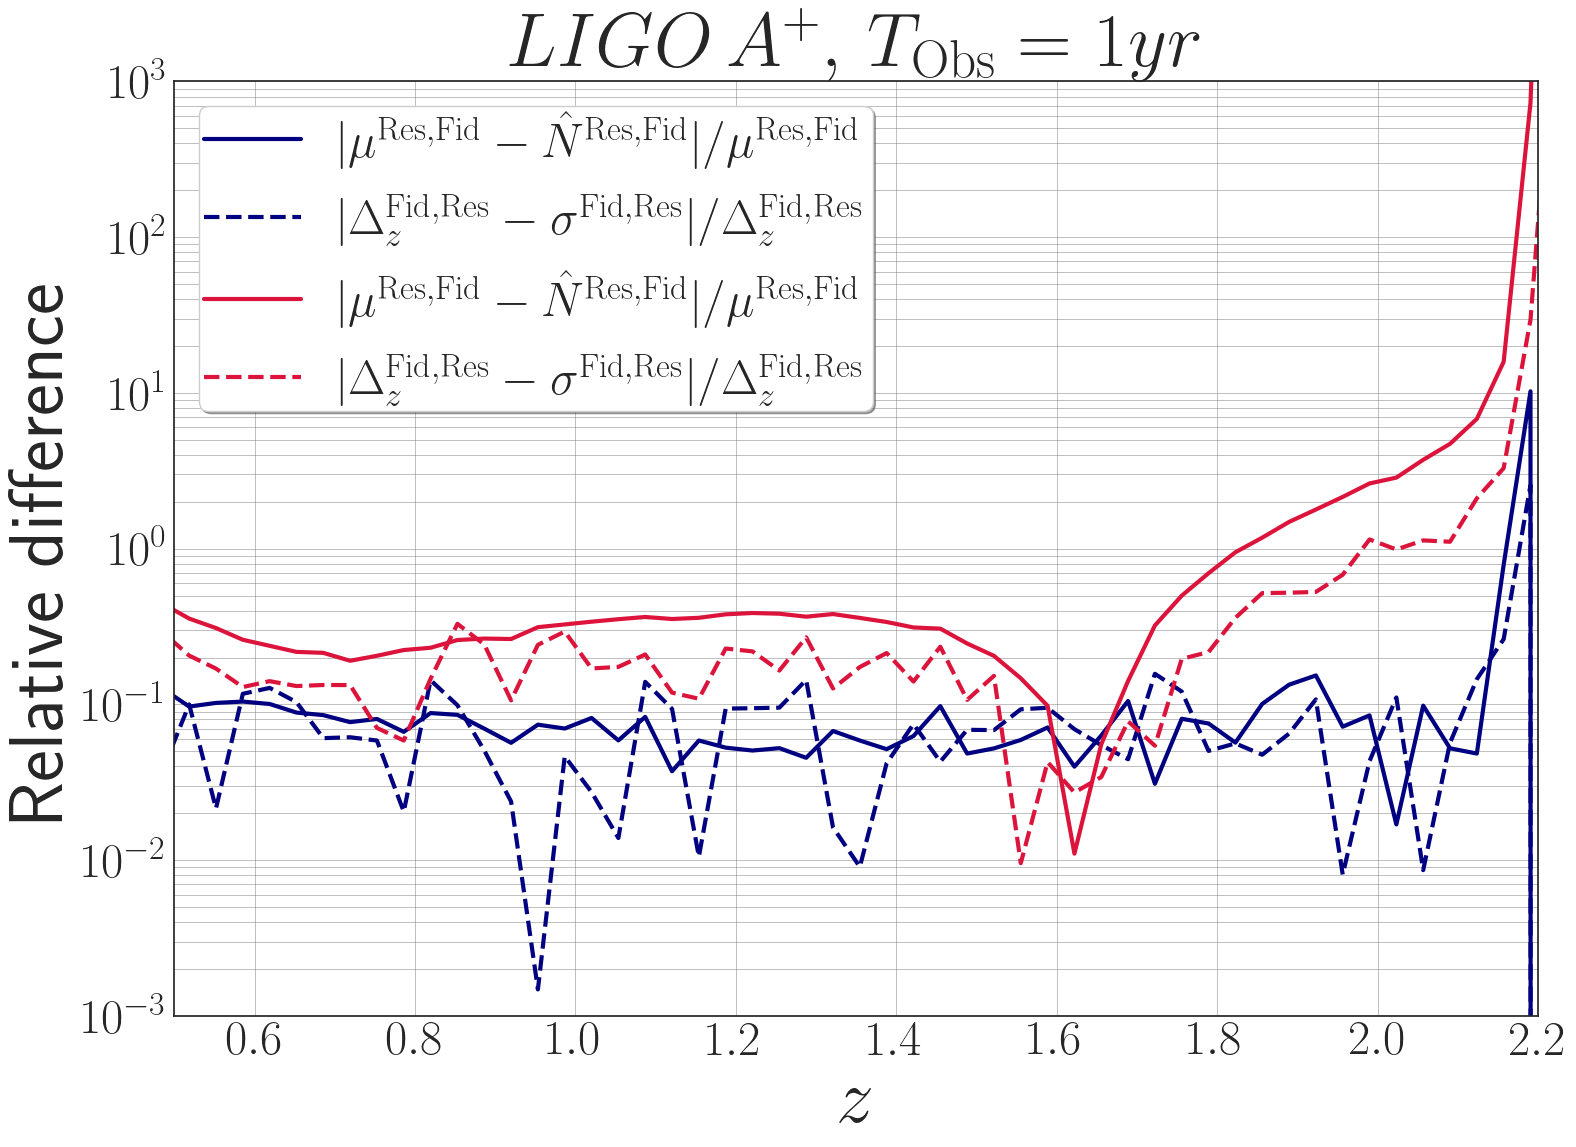

In [9]:
# Plotting the results for the LogNormal subpopulation

plt.figure(figsize=(16,12))
plt.plot(PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Redshift'], abs(LIGO_AnMuLin - PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Avg'])/LIGO_AnMuLin, color = 'navy', linewidth=3, label = r'$|\mu^{\rm Res, Fid} - \hat{N}^{\rm Res, Fid}|/\mu^{\rm Res, Fid}$')
plt.plot(PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Redshift'], abs(np.sqrt(LIGO_AnMuLin) - PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Sigma'])/np.sqrt(LIGO_AnMuLin), color = 'navy', linewidth=3, ls = 'dashed', label = r'$|\Delta^{\rm Fid, Res}_{z } - \sigma^{\rm Fid, Res}|/\Delta^{\rm Fid, Res}_{z}$')
plt.plot(PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Redshift'], abs(LIGO_AnMuLin - MauroNumReal['apLIGO_StatAnal']['Red_lin']['Avg'])/LIGO_AnMuLin, color = 'crimson', linewidth=3, label = r'$|\mu^{\rm Res, Fid} - \hat{N}^{\rm Res, Fid}|/\mu^{\rm Res, Fid}$')
plt.plot(PaoloNumReal['apLIGO_StatAnal']['Red_lin']['Redshift'], abs(np.sqrt(LIGO_AnMuLin) - MauroNumReal['apLIGO_StatAnal']['Red_lin']['Sigma'])/np.sqrt(LIGO_AnMuLin), color = 'crimson', linewidth=3, ls = 'dashed', label = r'$|\Delta^{\rm Fid, Res}_{z } - \sigma^{\rm Fid, Res}|/\Delta^{\rm Fid, Res}_{z}$')
plt.xlabel('$z$', fontsize = 55 )
plt.ylabel(r'Relative difference', fontsize = 55)
plt.xlim(0.5, 2.2)
plt.yscale('log')
plt.ylim(1.e-3,1.e3)
plt.legend(loc = 2, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 35})
#plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'$LIGO \, A^{+}, \, T_{\rm Obs} = 1yr$',fontsize = 55)
plt.tight_layout()
plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
plt.savefig('apLIGORelativeErrorLin.png',dpi=200)
#plt.savefig('apLIGORelativeErrorLin.png',dpi=50)

<h3> Plotting the results in logarithmic scale</h3>

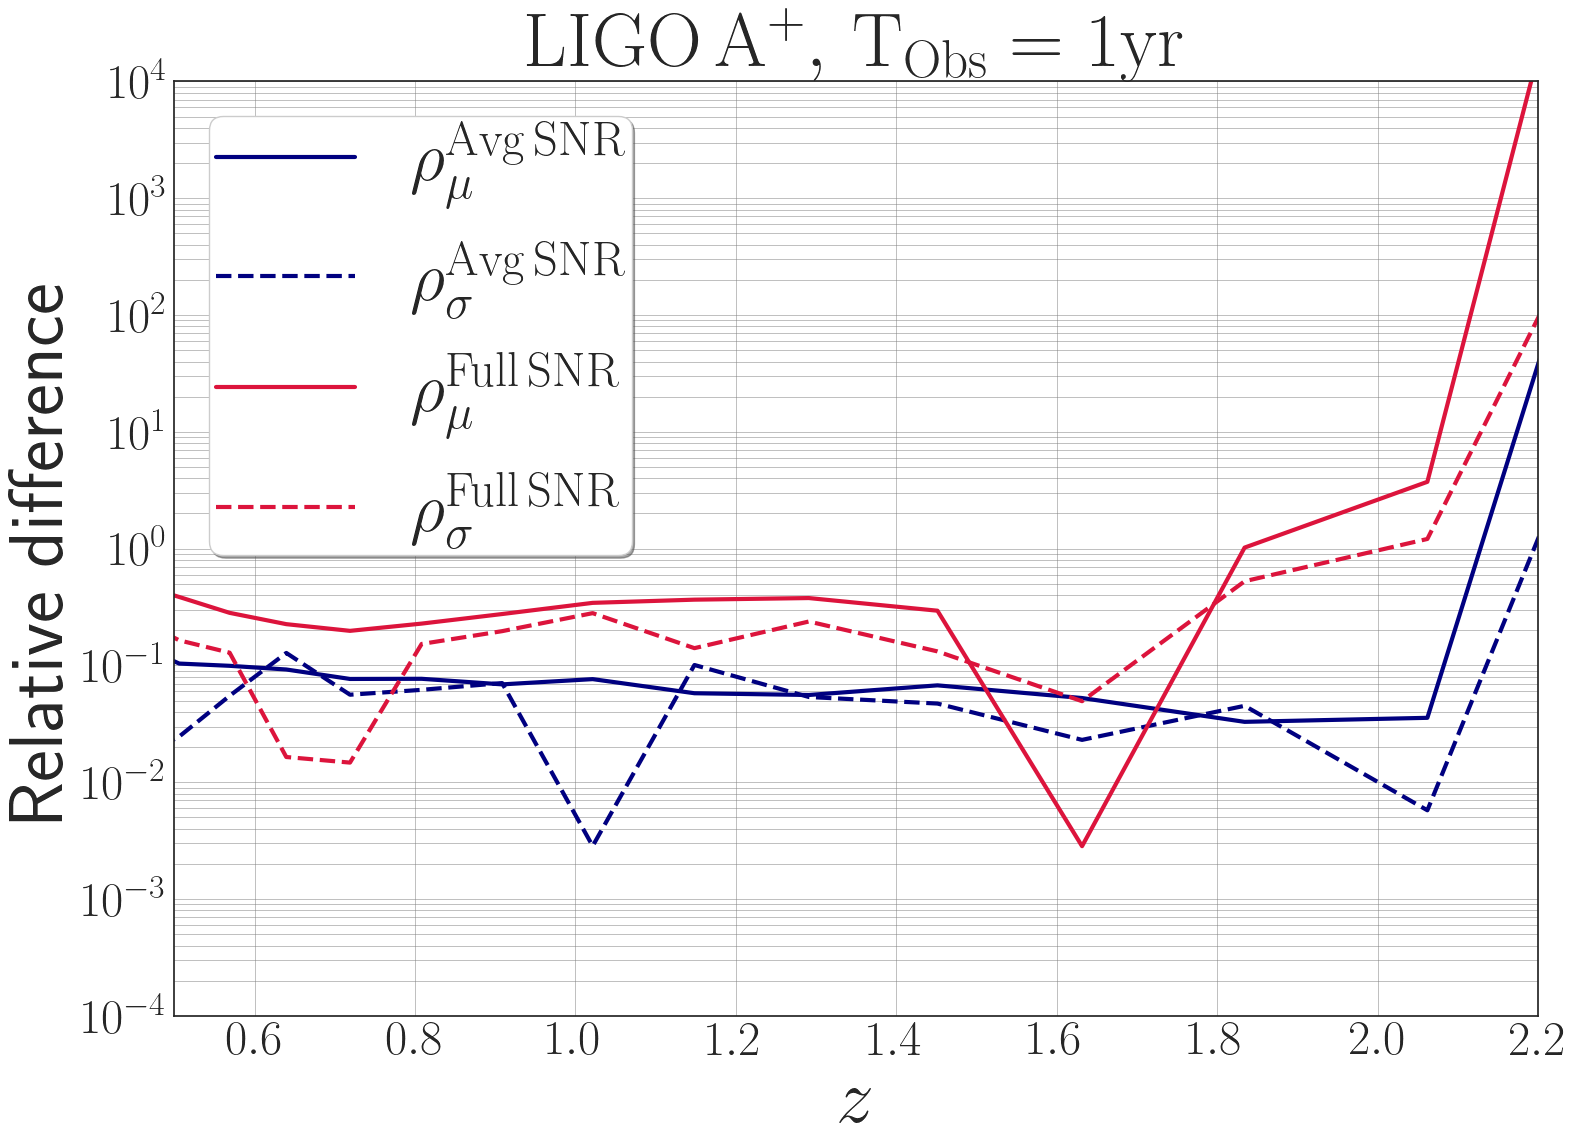

In [10]:
# Plotting the results for the LogNormal subpopulation

plt.figure(figsize=(16,12))
plt.plot(PaoloNumReal['apLIGO_StatAnal']['Red_log']['Redshift'], abs(LIGO_AnMu - PaoloNumReal['apLIGO_StatAnal']['Red_log']['Avg'])/LIGO_AnMu, color = 'navy', linewidth=3, label = r'$\rho_\mu^{\rm Avg \, SNR}$')
plt.plot(PaoloNumReal['apLIGO_StatAnal']['Red_log']['Redshift'], abs(np.sqrt(LIGO_AnMu) - PaoloNumReal['apLIGO_StatAnal']['Red_log']['Sigma'])/np.sqrt(LIGO_AnMu), color = 'navy', linewidth=3, ls = 'dashed', label = r'$\rho_\sigma^{\rm Avg \, SNR}$')
plt.plot(PaoloNumReal['apLIGO_StatAnal']['Red_log']['Redshift'], abs(LIGO_AnMu - MauroNumReal['apLIGO_StatAnal']['Red_log']['Avg'])/LIGO_AnMu, color = 'crimson', linewidth=3, label = r'$\rho_\mu^{\rm Full \, SNR}$')
plt.plot(PaoloNumReal['apLIGO_StatAnal']['Red_log']['Redshift'], abs(np.sqrt(LIGO_AnMu) - MauroNumReal['apLIGO_StatAnal']['Red_log']['Sigma'])/np.sqrt(LIGO_AnMu), color = 'crimson', linewidth=3, ls = 'dashed', label = r'$\rho_\sigma^{\rm Full \, SNR}$')
plt.xlabel('$z$', fontsize = 55 )
plt.ylabel(r'Relative difference', fontsize = 55)
plt.xlim(0.5, 2.2)
plt.yscale('log')
plt.ylim(1.e-4,1.e4)
plt.legend(loc = 2, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 50})
#plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'$\rm LIGO \, A^{+}, \, T_{\rm Obs} = 1yr$',fontsize = 55)
plt.tight_layout()
plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
plt.savefig('apLIGORelativeError.png',dpi=200)
#plt.savefig('apLIGORelativeError.png',dpi=50)

<h2> Plotting the results for ET </h2>

<h3> Plotting the results in linear scale</h3>

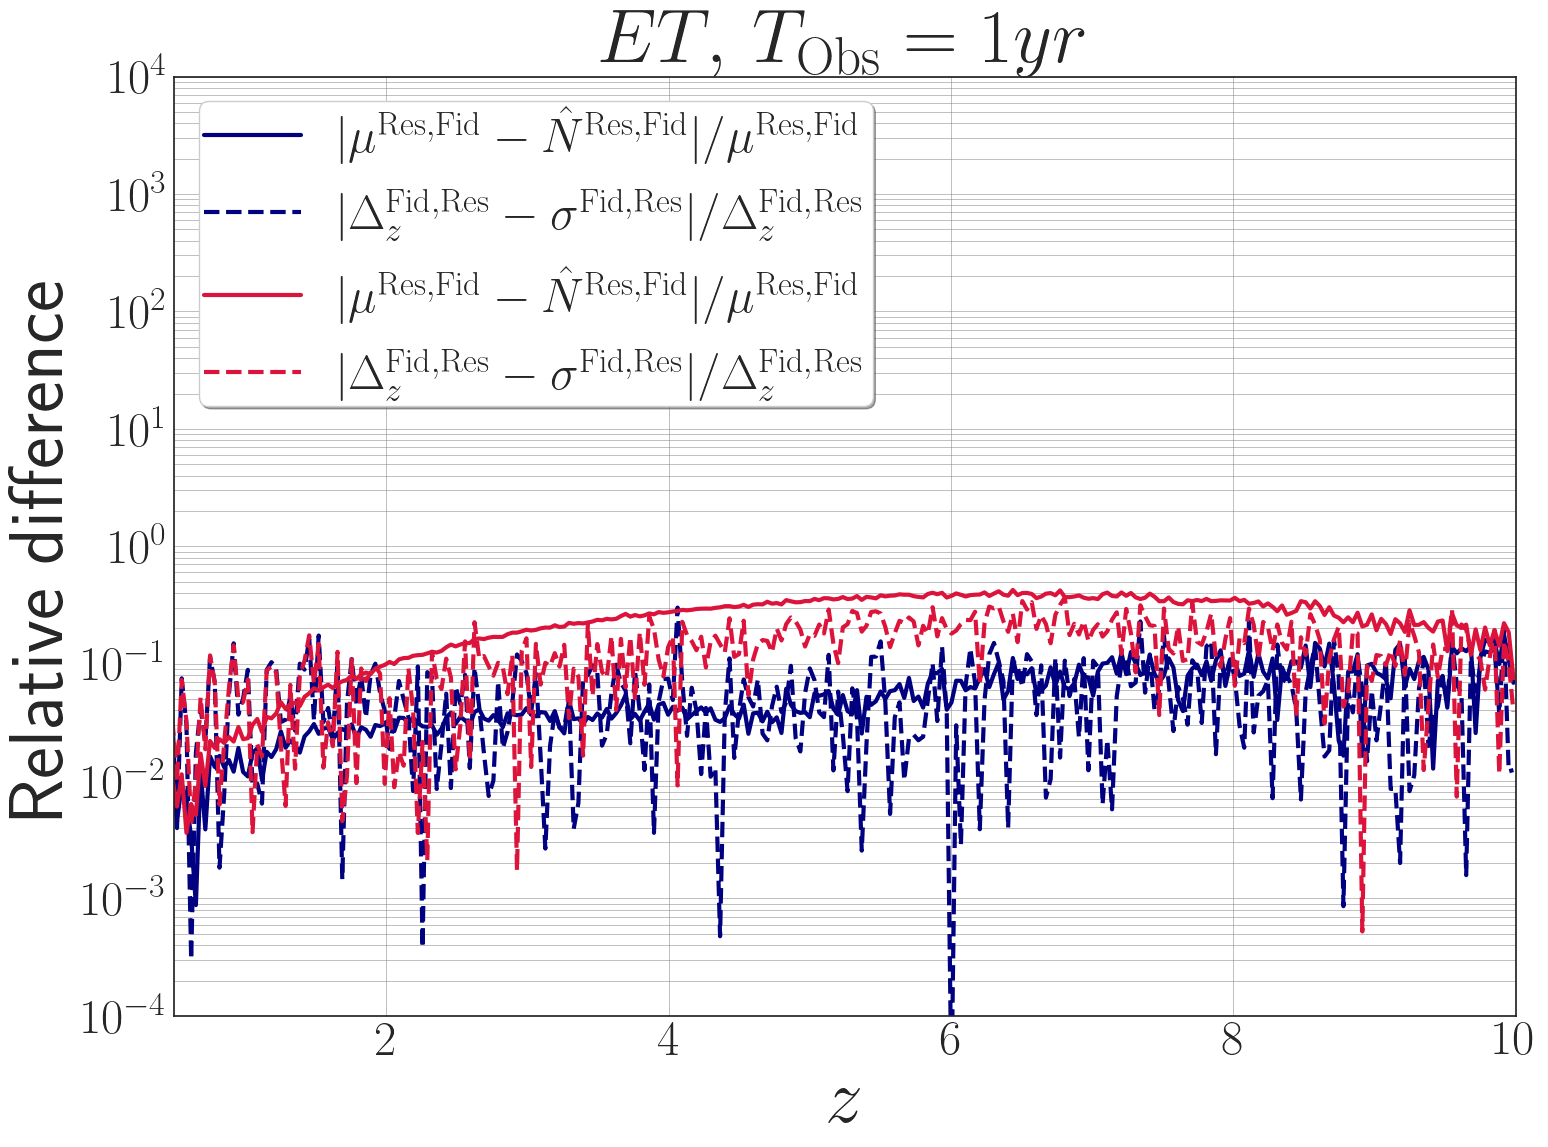

In [11]:
# Plotting the results for the LogNormal subpopulation

plt.figure(figsize=(16,12))
plt.plot(PaoloNumReal['ET_StatAnal']['Red_lin']['Redshift'], abs(ET_AnMuLin - PaoloNumReal['ET_StatAnal']['Red_lin']['Avg'])/ET_AnMuLin, color = 'navy', linewidth=3, label = r'$|\mu^{\rm Res, Fid} - \hat{N}^{\rm Res, Fid}|/\mu^{\rm Res, Fid}$')
plt.plot(PaoloNumReal['ET_StatAnal']['Red_lin']['Redshift'], abs(np.sqrt(ET_AnMuLin) - PaoloNumReal['ET_StatAnal']['Red_lin']['Sigma'])/np.sqrt(ET_AnMuLin), color = 'navy', linewidth=3, ls = 'dashed', label = r'$|\Delta^{\rm Fid, Res}_{z } - \sigma^{\rm Fid, Res}|/\Delta^{\rm Fid, Res}_{z}$')
plt.plot(PaoloNumReal['ET_StatAnal']['Red_lin']['Redshift'], abs(ET_AnMuLin - MauroNumReal['ET_StatAnal']['Red_lin']['Avg'])/ET_AnMuLin, color = 'crimson', linewidth=3, label = r'$|\mu^{\rm Res, Fid} - \hat{N}^{\rm Res, Fid}|/\mu^{\rm Res, Fid}$')
plt.plot(PaoloNumReal['ET_StatAnal']['Red_lin']['Redshift'], abs(np.sqrt(ET_AnMuLin) - MauroNumReal['ET_StatAnal']['Red_lin']['Sigma'])/np.sqrt(ET_AnMuLin), color = 'crimson', linewidth=3, ls = 'dashed', label = r'$|\Delta^{\rm Fid, Res}_{z } - \sigma^{\rm Fid, Res}|/\Delta^{\rm Fid, Res}_{z}$')
plt.xlabel('$z$', fontsize = 55 )
plt.ylabel(r'Relative difference', fontsize = 55)
plt.xlim(0.5, 10.)
plt.yscale('log')
plt.ylim(1.e-4,1.e4)
plt.legend(loc = 2, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 35})
#plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'$ET, \, T_{\rm Obs} = 1yr$',fontsize = 55)
plt.tight_layout()
plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
plt.savefig('ETRelativeErrorLin.png',dpi=200)
#plt.savefig('ETRelativeErrorLin.png',dpi=50)

<h3> Plotting the results in logarithmic scale</h3>

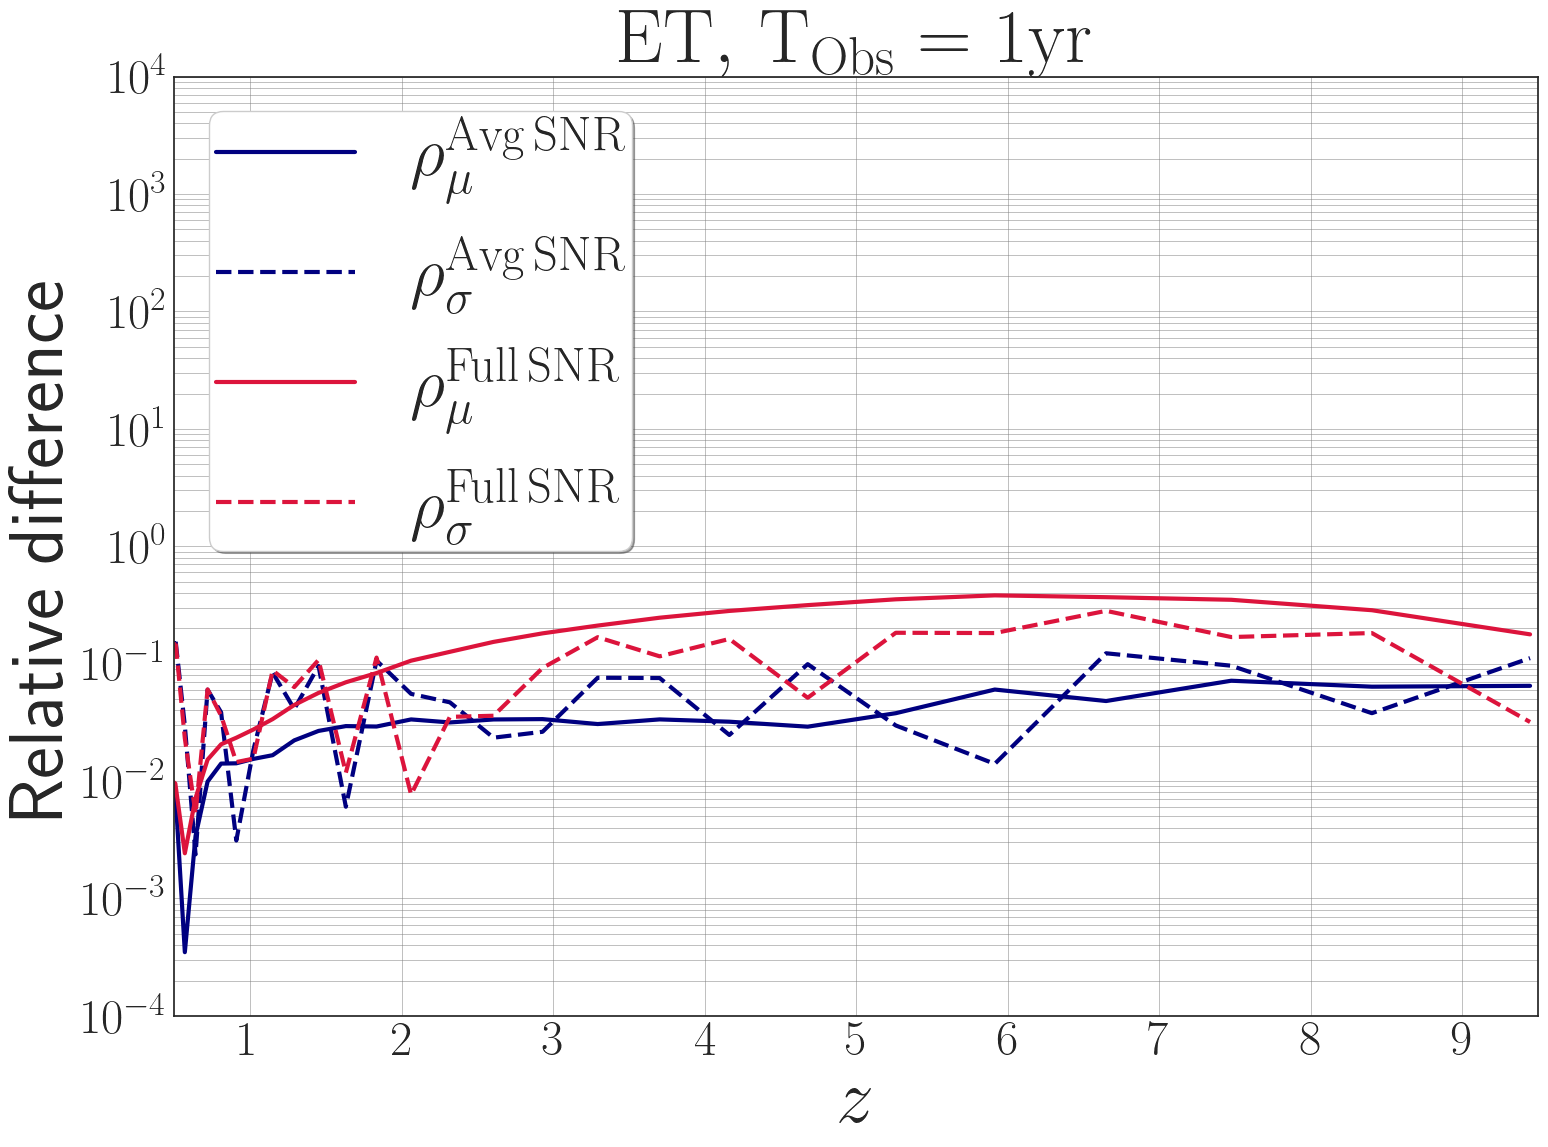

In [12]:
# Plotting the results for the LogNormal subpopulation

plt.figure(figsize=(16,12))
plt.plot(PaoloNumReal['ET_StatAnal']['Red_log']['Redshift'], abs(ET_AnMu - PaoloNumReal['ET_StatAnal']['Red_log']['Avg'])/ET_AnMu, color = 'navy', linewidth=3, label = r'$\rho_\mu^{\rm Avg \, SNR}$')
plt.plot(PaoloNumReal['ET_StatAnal']['Red_log']['Redshift'], abs(np.sqrt(ET_AnMu) - PaoloNumReal['ET_StatAnal']['Red_log']['Sigma'])/np.sqrt(ET_AnMu), color = 'navy', linewidth=3, ls = 'dashed', label = r'$\rho_\sigma^{\rm Avg \, SNR}$')
plt.plot(PaoloNumReal['ET_StatAnal']['Red_log']['Redshift'], abs(ET_AnMu - MauroNumReal['ET_StatAnal']['Red_log']['Avg'])/ET_AnMu, color = 'crimson', linewidth=3, label = r'$\rho_\mu^{\rm Full \, SNR}$')
plt.plot(PaoloNumReal['ET_StatAnal']['Red_log']['Redshift'], abs(np.sqrt(ET_AnMu) - MauroNumReal['ET_StatAnal']['Red_log']['Sigma'])/np.sqrt(ET_AnMu), color = 'crimson', linewidth=3, ls = 'dashed', label = r'$\rho_\sigma^{\rm Full \, SNR}$')
plt.xlabel('$z$', fontsize = 55 )
plt.ylabel(r'Relative difference', fontsize = 55)
plt.xlim(0.5, 9.5)
plt.yscale('log')
plt.ylim(1.e-4,1.e4)
plt.legend(loc = 2, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 50})
#plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'$\rm ET, \, T_{\rm Obs} = 1yr$',fontsize = 55)
plt.tight_layout()
plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
plt.savefig('ETRelativeError.png',dpi=200)
#plt.savefig('ETRelativeError.png',dpi=50)